In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import seaborn as sns
from PIL import Image

# Import scatter function
sys.path.append('..')
from scatter import create_diamond_scatter

# Load environment
load_dotenv()

# Visual constants (FootballDecoded style)
BACKGROUND_COLOR = '#313332'
FONT_FAMILY = 'DejaVu Sans'
node_cmap = mcolors.LinearSegmentedColormap.from_list("", [
    'deepskyblue', 'cyan', 'lawngreen', 'yellow',
    'gold', 'lightpink', 'tomato'
])

# Configure matplotlib
mpl.rcParams['xtick.color'] = 'w'
mpl.rcParams['ytick.color'] = 'w'
mpl.rcParams['text.color'] = 'w'
mpl.rcParams['font.family'] = FONT_FAMILY

# Create output directory
os.makedirs('figures', exist_ok=True)

print("Setup complete")

Setup complete


In [2]:
# Connect to database
connection_string = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
engine = create_engine(connection_string)

# Query: Big 5 leagues, season 2425, 800+ mins, with understat data
query = text("""
    SELECT 
        player_name,
        position,
        team,
        league,
        season,
        fbref_metrics->>'minutes_played' as minutes,
        fbref_metrics->>'goals' as goals,
        fbref_metrics->>'assists' as assists,
        fbref_metrics->>'expected_goals' as xg,
        fbref_metrics->>'expected_assists' as xa,
        understat_metrics->>'understat_xg_chain' as xg_chain,
        understat_metrics->>'understat_xg_buildup' as xg_buildup
    FROM footballdecoded.players_domestic 
    WHERE season = '2425'
    AND league = ANY(ARRAY['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1'])
    AND CAST(fbref_metrics->>'minutes_played' AS FLOAT) >= 800
    AND understat_metrics->>'understat_xg_chain' IS NOT NULL
    AND understat_metrics->>'understat_xg_buildup' IS NOT NULL
""")

with engine.connect() as conn:
    df = pd.read_sql(query, conn)

# Convert to numeric
numeric_cols = ['minutes', 'goals', 'assists', 'xg', 'xa', 'xg_chain', 'xg_buildup']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate derived metrics
df['g_plus_a'] = df['goals'] + df['assists']
df['final_third_impact'] = df['xg_chain'] - df['xg_buildup']
df['chain_buildup_ratio'] = df['xg_chain'] / df['xg_buildup'].replace(0, np.nan)
df['total_contribution'] = df['xg_chain'] + df['xg_buildup']

# Clean position (simplify multi-position)
df['position_clean'] = df['position'].apply(lambda x: x.split(',')[0] if pd.notna(x) else 'Unknown')

# Filter main positions only (exclude GK)
df_field = df[df['position_clean'].isin(['DF', 'MF', 'FW'])].copy()

print(f"Total players loaded: {len(df)}")
print(f"Field players (DF/MF/FW): {len(df_field)}")
print(f"\nPosition distribution:")
print(df_field['position_clean'].value_counts())

df_field.head()

Total players loaded: 1581
Field players (DF/MF/FW): 1464

Position distribution:
position_clean
DF    621
MF    493
FW    350
Name: count, dtype: int64


,player_name,position,team,league,season,minutes,goals,assists,xg,xa,xg_chain,xg_buildup,g_plus_a,final_third_impact,chain_buildup_ratio,total_contribution,position_clean
0,Alexsandro Ribeiro,DF,Lille,FRA-Ligue 1,2425,2700.0,1,1,1.6,0.4,11.815566,11.478280,2,0.337287,1.029385,23.293846,DF
1,Marc Casado,MF,Barcelona,ESP-La Liga,2425,1611.0,1,3,1.1,1.4,1.513912,1.446811,4,0.067100,1.046378,2.960723,MF
2,Pau Cubarsí,DF,Barcelona,ESP-La Liga,2425,2618.0,0,3,0.8,1.6,17.255912,17.147911,3,0.108001,1.006298,34.403823,DF
3,Pedri,MF,Barcelona,ESP-La Liga,2425,2879.0,4,5,2.2,7.4,31.426336,23.621034,9,7.805302,1.330439,55.047371,MF
4,Raphinha,"FW,MF",Barcelona,ESP-La Liga,2425,2839.0,18,9,19.2,12.7,39.282579,13.650435,27,25.632143,2.877753,52.933014,FW


In [3]:
def add_footer(fig):
    """
    Add standard FootballDecoded footer to figure.
    """
    # Footer text
    fig.text(0.05, -0.065, "Created by Jaime Oriol", fontweight='bold', 
             fontsize=12, color="white", fontfamily=FONT_FAMILY)
    
    # Try to add logo
    try:
        logo_path = "../../blog/logo/Logo-blanco.png"
        if os.path.exists(logo_path):
            logo = Image.open(logo_path)
            logo_ax = fig.add_axes([0.675, -0.12, 0.4, 0.2])
            logo_ax.imshow(logo)
            logo_ax.axis('off')
        else:
            fig.text(0.6, 0.02, "Football Decoded", fontweight='bold', 
                    fontsize=14, color="white", fontfamily=FONT_FAMILY)
    except:
        fig.text(0.6, 0.02, "Football Decoded", fontweight='bold', 
                fontsize=14, color="white", fontfamily=FONT_FAMILY)


def create_histogram(data, metric_name, title, xlabel, bins=30, color='deepskyblue', save_name=None):
    """
    Create histogram following FootballDecoded style.
    """
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=BACKGROUND_COLOR)
    ax.set_facecolor(BACKGROUND_COLOR)
    
    # Histogram
    n, bins_edges, patches = ax.hist(data.dropna(), bins=bins, color=color, 
                                       edgecolor='white', alpha=0.8, linewidth=1.2)
    
    # Calculate percentiles for reference lines
    p20 = data.quantile(0.20)
    p50 = data.quantile(0.50)
    p80 = data.quantile(0.80)
    
    # Add percentile lines
    ax.axvline(p20, color='yellow', linestyle='--', alpha=0.6, linewidth=1.5, label=f'P20: {p20:.1f}')
    ax.axvline(p50, color='gold', linestyle='--', alpha=0.8, linewidth=2, label=f'P50: {p50:.1f}')
    ax.axvline(p80, color='tomato', linestyle='--', alpha=0.6, linewidth=1.5, label=f'P80: {p80:.1f}')
    
    # Styling
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold', color='white')
    ax.set_ylabel('Number of Players', fontsize=12, fontweight='bold', color='white')
    ax.set_title(title, fontsize=14, fontweight='bold', color='white', pad=20)
    ax.grid(alpha=0.2, color='white')
    ax.legend(loc='upper right', framealpha=0.9, facecolor=BACKGROUND_COLOR, edgecolor='white')
    
    # Spines
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    
    # Add footer
    add_footer(fig)
    
    if save_name:
        fig.savefig(f'figures/{save_name}', 
                   dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
    
    return fig, ax


def create_boxplot_by_position(df, metric, title, ylabel, save_name=None):
    """
    Create box plot by position following FootballDecoded style.
    """
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=BACKGROUND_COLOR)
    ax.set_facecolor(BACKGROUND_COLOR)
    
    # Prepare data by position
    positions = ['DF', 'MF', 'FW']
    data_by_pos = [df[df['position_clean'] == pos][metric].dropna() for pos in positions]
    
    # Box plot
    bp = ax.boxplot(data_by_pos, labels=positions, patch_artist=True,
                    boxprops=dict(facecolor='deepskyblue', alpha=0.7, edgecolor='white', linewidth=1.5),
                    whiskerprops=dict(color='white', linewidth=1.5),
                    capprops=dict(color='white', linewidth=1.5),
                    medianprops=dict(color='gold', linewidth=2.5),
                    flierprops=dict(marker='o', markerfacecolor='tomato', markersize=6, 
                                   markeredgecolor='white', alpha=0.6))
    
    # Add mean markers
    means = [data.mean() for data in data_by_pos]
    ax.plot(range(1, len(positions)+1), means, 'D', color='lawngreen', 
           markersize=10, markeredgecolor='white', markeredgewidth=1.5, label='Mean', zorder=3)
    
    # Styling
    ax.set_xlabel('Position', fontsize=12, fontweight='bold', color='white')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold', color='white')
    ax.set_title(title, fontsize=14, fontweight='bold', color='white', pad=20)
    ax.grid(alpha=0.2, color='white', axis='y')
    ax.legend(loc='upper right', framealpha=0.9, facecolor=BACKGROUND_COLOR, edgecolor='white')
    
    # Spines
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    
    # Add footer
    add_footer(fig)
    
    if save_name:
        fig.savefig(f'figures/{save_name}', 
                   dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
    
    return fig, ax


def create_bar_comparison(categories, values, title, ylabel, colors=None, save_name=None):
    """
    Create bar chart comparison following FootballDecoded style.
    """
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=BACKGROUND_COLOR)
    ax.set_facecolor(BACKGROUND_COLOR)
    
    if colors is None:
        colors = ['deepskyblue', 'lawngreen', 'gold', 'tomato'][:len(categories)]
    
    # Bar chart
    bars = ax.bar(categories, values, color=colors, edgecolor='white', linewidth=1.5, alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}',
               ha='center', va='bottom', color='white', fontweight='bold', fontsize=11)
    
    # Styling
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold', color='white')
    ax.set_title(title, fontsize=14, fontweight='bold', color='white', pad=20)
    ax.grid(alpha=0.2, color='white', axis='y')
    
    # Spines
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    
    # Add footer
    add_footer(fig)
    
    if save_name:
        fig.savefig(f'figures/{save_name}', 
                   dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
    
    return fig, ax


def create_scatter_production(df, save_name=None):
    """
    Scatter: Total Contribution (Chain+Buildup) vs Production (G+A).
    Shows if high contributors actually produce goals.
    """
    fig, ax = plt.subplots(figsize=(12, 8), facecolor=BACKGROUND_COLOR)
    ax.set_facecolor(BACKGROUND_COLOR)
    
    # Position colors
    pos_colors = {'DF': 'deepskyblue', 'MF': 'lawngreen', 'FW': 'tomato'}
    
    # Scatter by position
    for pos in ['DF', 'MF', 'FW']:
        df_pos = df[df['position_clean'] == pos]
        ax.scatter(df_pos['total_contribution'], df_pos['g_plus_a'], 
                  c=pos_colors[pos], label=pos, s=60, alpha=0.7, edgecolor='white', linewidth=0.5)
    
    # Add diagonal reference line (expected: G+A scales with contribution)
    max_val = max(df['total_contribution'].max(), df['g_plus_a'].max())
    ax.plot([0, max_val], [0, max_val], '--', color='yellow', alpha=0.4, linewidth=2, label='Expected')
    
    # Label top 10 by G+A
    top10 = df.nlargest(10, 'g_plus_a')
    for _, player in top10.iterrows():
        name_parts = player['player_name'].split(' ')
        if len(name_parts) > 1:
            label = f"{name_parts[0][0]}. {name_parts[-1]}"
        else:
            label = name_parts[0]
        
        ax.annotate(label, 
                   xy=(player['total_contribution'], player['g_plus_a']),
                   xytext=(8, 8), textcoords='offset points',
                   fontsize=9, color='yellow', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor=BACKGROUND_COLOR, 
                            edgecolor='yellow', alpha=0.9, linewidth=1))
    
    # Styling
    ax.set_xlabel('Total Contribution (xG Chain + xG Buildup)', fontsize=12, fontweight='bold', color='white')
    ax.set_ylabel('Production (Goals + Assists)', fontsize=12, fontweight='bold', color='white')
    ax.set_title('Contribution vs Production - Big 5 Leagues (2024-25)', 
                fontsize=14, fontweight='bold', color='white', pad=20)
    ax.grid(alpha=0.2, color='white')
    ax.legend(loc='upper left', framealpha=0.9, facecolor=BACKGROUND_COLOR, edgecolor='white')
    
    # Spines
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    
    # Add footer
    add_footer(fig)
    
    if save_name:
        fig.savefig(f'figures/{save_name}', 
                   dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
    
    return fig, ax


def create_grouped_bar_chain_buildup(df, save_name=None):
    """
    Grouped bar chart comparing Chain vs Buildup by quadrant archetype.
    """
    fig, ax = plt.subplots(figsize=(12, 7), facecolor=BACKGROUND_COLOR)
    ax.set_facecolor(BACKGROUND_COLOR)
    
    # Calculate averages by quadrant
    quad_stats = df.groupby('quadrant')[['xg_chain', 'xg_buildup']].mean()
    
    # Order: Complete, Finisher, Architect, Limited
    order = ['Complete', 'Finisher', 'Architect', 'Limited']
    quad_stats = quad_stats.reindex(order)
    
    # Bar positions
    x = np.arange(len(order))
    width = 0.35
    
    # Bars
    bars1 = ax.bar(x - width/2, quad_stats['xg_chain'], width, 
                   label='xG Chain', color='deepskyblue', edgecolor='white', linewidth=1.5, alpha=0.8)
    bars2 = ax.bar(x + width/2, quad_stats['xg_buildup'], width, 
                   label='xG Buildup', color='lawngreen', edgecolor='white', linewidth=1.5, alpha=0.8)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', color='white', fontweight='bold', fontsize=10)
    
    # Styling
    ax.set_ylabel('Average xG', fontsize=12, fontweight='bold', color='white')
    ax.set_title('Average xG Chain vs xG Buildup by Player Archetype', 
                fontsize=14, fontweight='bold', color='white', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(order, fontsize=11, fontweight='bold')
    ax.legend(loc='upper right', framealpha=0.9, facecolor=BACKGROUND_COLOR, edgecolor='white')
    ax.grid(alpha=0.2, color='white', axis='y')
    
    # Spines
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linewidth(1.5)
    
    plt.tight_layout()
    
    # Add footer
    add_footer(fig)
    
    if save_name:
        fig.savefig(f'figures/{save_name}', 
                   dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
    
    return fig, ax


def create_team_table(team_summary, top_n=15, save_name=None):
    """
    Create visual table of teams with integrated horizontal bars.
    """
    # Get top N teams by % complete
    df_teams = team_summary.nlargest(top_n, 'pct_complete').copy()
    
    # Normalize metrics for bar visualization (0-1)
    df_teams['pct_complete_norm'] = df_teams['pct_complete'] / 100
    df_teams['xg_chain_norm'] = df_teams['xg_chain'] / df_teams['xg_chain'].max()
    df_teams['g_plus_a_norm'] = df_teams['g_plus_a'] / df_teams['g_plus_a'].max()
    
    fig, ax = plt.subplots(figsize=(14, 10), facecolor=BACKGROUND_COLOR)
    ax.set_facecolor(BACKGROUND_COLOR)
    ax.axis('off')
    
    # Table parameters
    row_height = 0.6
    col_widths = [0.25, 0.12, 0.18, 0.18, 0.18]
    start_y = top_n * row_height
    
    # Header
    headers = ['Team', '# Players', '% Complete', 'Total xG Chain', 'Total G+A']
    x_pos = 0
    for i, (header, width) in enumerate(zip(headers, col_widths)):
        ax.text(x_pos + width/2, start_y + 0.3, header, 
               ha='center', va='center', fontsize=11, fontweight='bold', color='gold')
        x_pos += width
    
    # Header line
    ax.plot([0, 1], [start_y, start_y], color='white', linewidth=2)
    
    # Rows
    for idx, (team_name, row) in enumerate(df_teams.iterrows()):
        y_pos = start_y - (idx + 1) * row_height
        
        # Alternating row background
        if idx % 2 == 0:
            rect = Rectangle((0, y_pos - row_height/2), 1, row_height, 
                           facecolor='white', alpha=0.05, zorder=0)
            ax.add_patch(rect)
        
        # Team name
        ax.text(col_widths[0]/2, y_pos, team_name, 
               ha='center', va='center', fontsize=10, color='white', fontweight='bold')
        
        # Number of players
        x_pos = col_widths[0]
        ax.text(x_pos + col_widths[1]/2, y_pos, f"{int(row['num_players'])}", 
               ha='center', va='center', fontsize=10, color='white')
        
        # % Complete (bar + text)
        x_pos += col_widths[1]
        bar_x = x_pos + 0.01
        bar_width = col_widths[2] - 0.02
        bar_height_pct = 0.3
        
        rect_bg = Rectangle((bar_x, y_pos - bar_height_pct/2), bar_width, bar_height_pct,
                           facecolor='white', alpha=0.1, zorder=1)
        ax.add_patch(rect_bg)
        
        rect_val = Rectangle((bar_x, y_pos - bar_height_pct/2), 
                            bar_width * row['pct_complete_norm'], bar_height_pct,
                            facecolor='gold', alpha=0.8, zorder=2)
        ax.add_patch(rect_val)
        
        ax.text(x_pos + col_widths[2]/2, y_pos, f"{row['pct_complete']:.1f}%", 
               ha='center', va='center', fontsize=9, color='white', fontweight='bold', zorder=3)
        
        # xG Chain (bar + text)
        x_pos += col_widths[2]
        bar_x = x_pos + 0.01
        
        rect_bg = Rectangle((bar_x, y_pos - bar_height_pct/2), bar_width, bar_height_pct,
                           facecolor='white', alpha=0.1, zorder=1)
        ax.add_patch(rect_bg)
        
        rect_val = Rectangle((bar_x, y_pos - bar_height_pct/2), 
                            bar_width * row['xg_chain_norm'], bar_height_pct,
                            facecolor='deepskyblue', alpha=0.8, zorder=2)
        ax.add_patch(rect_val)
        
        ax.text(x_pos + col_widths[3]/2, y_pos, f"{row['xg_chain']:.1f}", 
               ha='center', va='center', fontsize=9, color='white', fontweight='bold', zorder=3)
        
        # G+A (bar + text)
        x_pos += col_widths[3]
        bar_x = x_pos + 0.01
        
        rect_bg = Rectangle((bar_x, y_pos - bar_height_pct/2), bar_width, bar_height_pct,
                           facecolor='white', alpha=0.1, zorder=1)
        ax.add_patch(rect_bg)
        
        rect_val = Rectangle((bar_x, y_pos - bar_height_pct/2), 
                            bar_width * row['g_plus_a_norm'], bar_height_pct,
                            facecolor='tomato', alpha=0.8, zorder=2)
        ax.add_patch(rect_val)
        
        ax.text(x_pos + col_widths[4]/2, y_pos, f"{int(row['g_plus_a'])}", 
               ha='center', va='center', fontsize=9, color='white', fontweight='bold', zorder=3)
    
    # Title
    ax.text(0.5, start_y + 1.0, f'Top {top_n} Teams by % Complete Players - Big 5 Leagues (2024-25)', 
           ha='center', va='center', fontsize=14, fontweight='bold', color='white')
    
    # Set limits
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, start_y + 1.5)
    
    if save_name:
        fig.savefig(f'figures/{save_name}', 
                   dpi=300, facecolor=BACKGROUND_COLOR, bbox_inches='tight')
    
    return fig, ax


print("All helper functions loaded")

All helper functions loaded


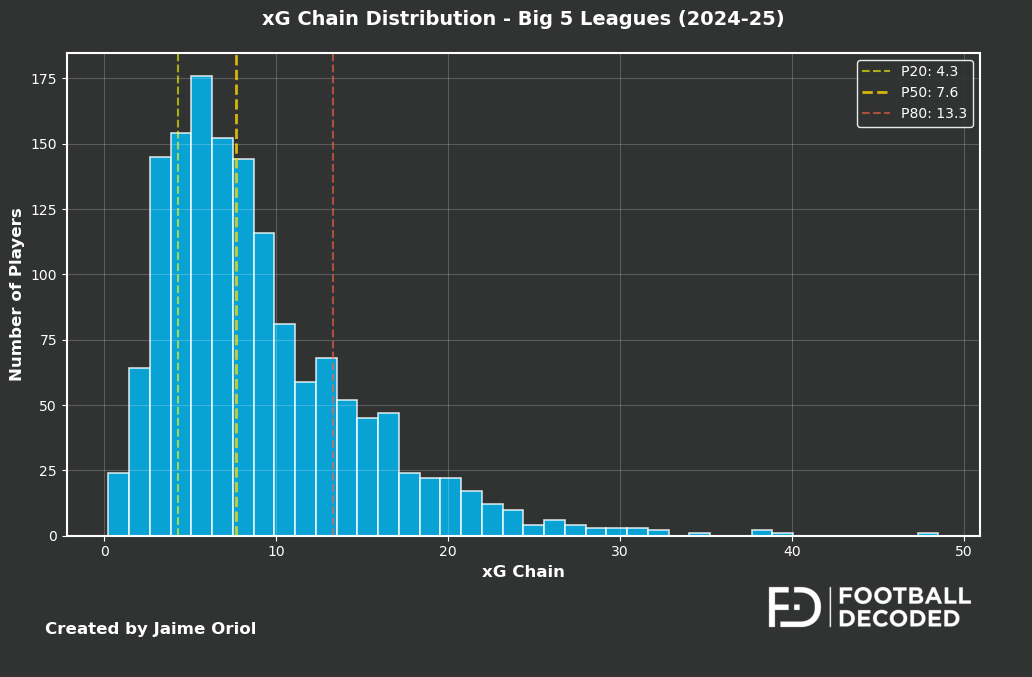


xG Chain Statistics:
Mean: 9.07
Median: 7.65
P90: 16.84
Max: 48.54

Top 10 xG Chain:
    player_name position           team  xg_chain
  Mohamed Salah       FW      Liverpool 48.535889
       Raphinha    FW,MF      Barcelona 39.282579
  Kylian Mbappé       FW    Real Madrid 38.313464
   Lamine Yamal       FW      Barcelona 38.307875
Bradley Barcola       FW      Paris S-G 34.758061
   Hugo Ekitike       FW Eint Frankfurt 32.081095
Ousmane Dembélé       FW      Paris S-G 32.066799
 Joshua Kimmich       MF  Bayern Munich 31.528941
          Pedri       MF      Barcelona 31.426336
  Michael Olise    FW,MF  Bayern Munich 31.133057


In [4]:
# Histogram: xG Chain distribution
fig, ax = create_histogram(
    data=df_field['xg_chain'],
    metric_name='xG Chain',
    title='xG Chain Distribution - Big 5 Leagues (2024-25)',
    xlabel='xG Chain',
    bins=40,
    color='deepskyblue',
    save_name='01_xg_chain_distribution.png'
)
plt.show()

# Statistics
print(f"\nxG Chain Statistics:")
print(f"Mean: {df_field['xg_chain'].mean():.2f}")
print(f"Median: {df_field['xg_chain'].median():.2f}")
print(f"P90: {df_field['xg_chain'].quantile(0.90):.2f}")
print(f"Max: {df_field['xg_chain'].max():.2f}")

# Top 10 xG Chain
top10_chain = df_field.nlargest(10, 'xg_chain')[['player_name', 'position', 'team', 'xg_chain']]
print(f"\nTop 10 xG Chain:")
print(top10_chain.to_string(index=False))

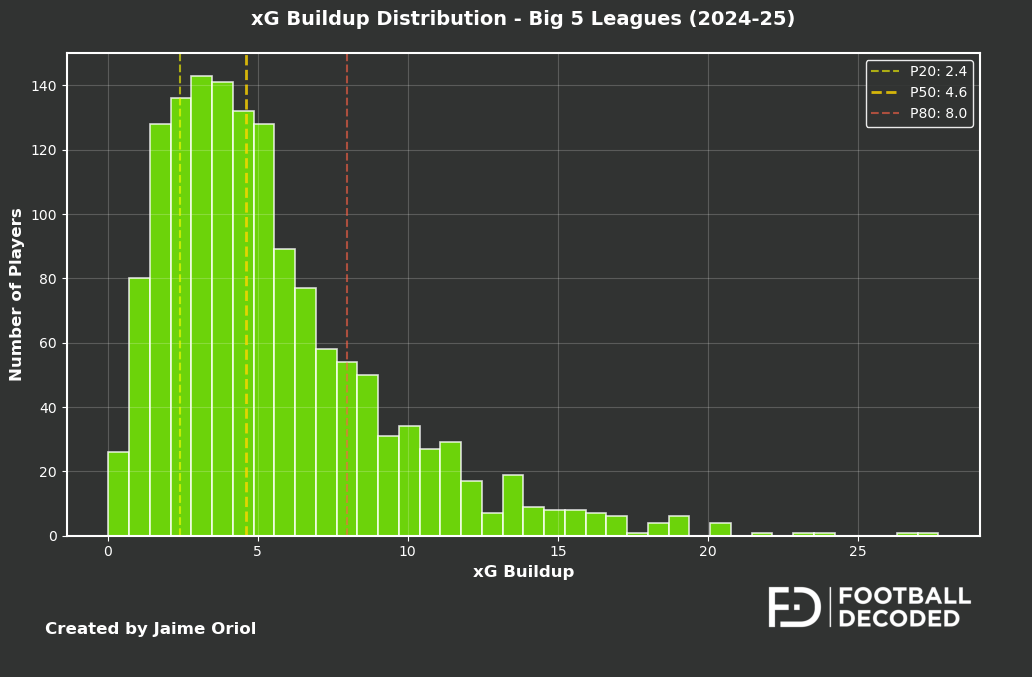


xG Buildup Statistics:
Mean: 5.48
Median: 4.63
P90: 10.68
Max: 27.68

Top 10 xG Buildup:
      player_name position          team  xg_buildup
   Joshua Kimmich       MF Bayern Munich   27.680503
          Vitinha       MF     Paris S-G   26.460083
            Pedri       MF     Barcelona   23.621034
Federico Valverde    MF,DF   Real Madrid   23.317612
  Virgil van Dijk       DF     Liverpool   21.517376
 Fabián Ruiz Peña       MF     Paris S-G   20.667620
    Achraf Hakimi       DF     Paris S-G   20.622446
     Jules Koundé       DF     Barcelona   20.274256
  Pierre Højbjerg       MF     Marseille   20.145436
 Ryan Gravenberch       MF     Liverpool   19.362357


In [5]:
# Histogram: xG Buildup distribution
fig, ax = create_histogram(
    data=df_field['xg_buildup'],
    metric_name='xG Buildup',
    title='xG Buildup Distribution - Big 5 Leagues (2024-25)',
    xlabel='xG Buildup',
    bins=40,
    color='lawngreen',
    save_name='02_xg_buildup_distribution.png'
)
plt.show()

# Statistics
print(f"\nxG Buildup Statistics:")
print(f"Mean: {df_field['xg_buildup'].mean():.2f}")
print(f"Median: {df_field['xg_buildup'].median():.2f}")
print(f"P90: {df_field['xg_buildup'].quantile(0.90):.2f}")
print(f"Max: {df_field['xg_buildup'].max():.2f}")

# Top 10 xG Buildup
top10_buildup = df_field.nlargest(10, 'xg_buildup')[['player_name', 'position', 'team', 'xg_buildup']]
print(f"\nTop 10 xG Buildup:")
print(top10_buildup.to_string(index=False))

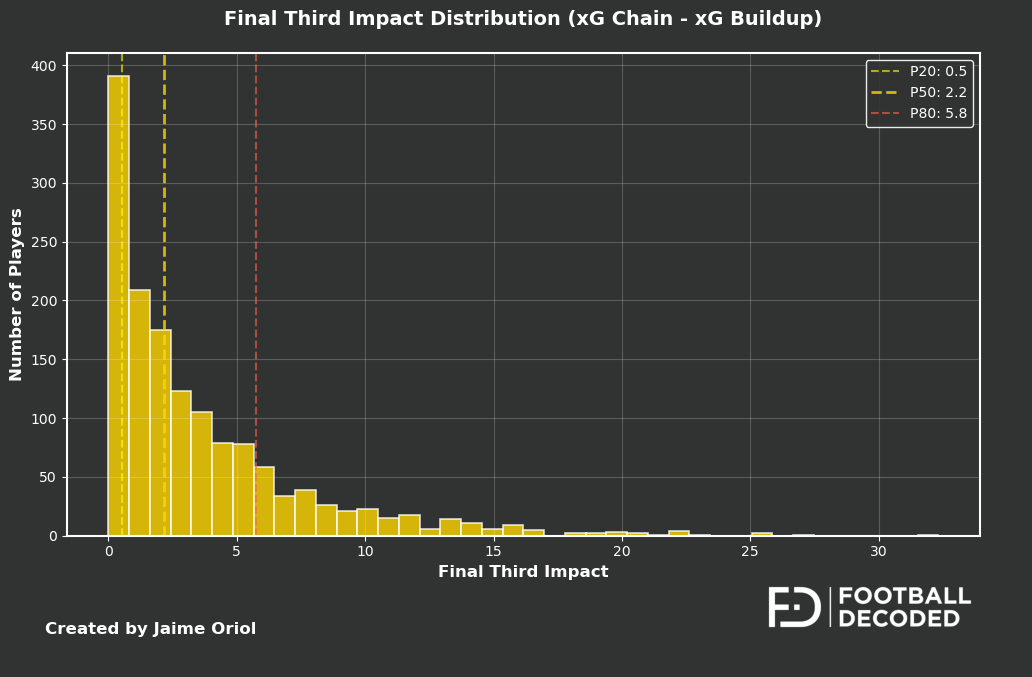


Player Archetypes:
Architect: 691 (47.2%)
Balanced: 410 (28.0%)
Finisher: 363 (24.8%)


In [6]:
# Histogram: Final Third Impact (Chain - Buildup)
fig, ax = create_histogram(
    data=df_field['final_third_impact'],
    metric_name='Final Third Impact',
    title='Final Third Impact Distribution (xG Chain - xG Buildup)',
    xlabel='Final Third Impact',
    bins=40,
    color='gold',
    save_name='03_final_third_impact_distribution.png'
)
plt.show()

# Categorize players
def categorize_player(row):
    diff = row['final_third_impact']
    if diff < 2:
        return 'Architect'
    elif diff < 5:
        return 'Balanced'
    else:
        return 'Finisher'

df_field['archetype'] = df_field.apply(categorize_player, axis=1)

# Distribution by archetype
archetype_counts = df_field['archetype'].value_counts()
archetype_pct = (archetype_counts / len(df_field) * 100).round(1)

print(f"\nPlayer Archetypes:")
for arch in ['Architect', 'Balanced', 'Finisher']:
    if arch in archetype_counts.index:
        print(f"{arch}: {archetype_counts[arch]} ({archetype_pct[arch]}%)")

/tmp/ipykernel_84210/3093605716.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_pos, labels=positions, patch_artist=True,


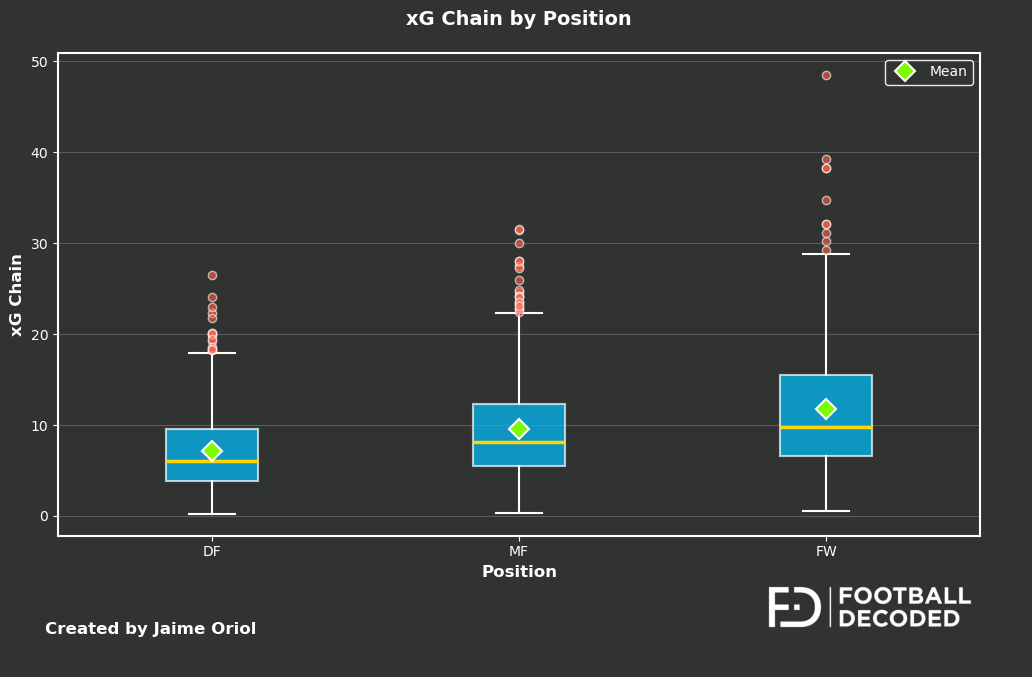


xG Chain by Position:
                     mean       50%        max
position_clean                                
DF               7.121314  6.044815  26.464711
FW              11.763563  9.832232  48.535889
MF               9.613626  8.120182  31.528941


In [7]:
# Box plot: xG Chain by position
fig, ax = create_boxplot_by_position(
    df=df_field,
    metric='xg_chain',
    title='xG Chain by Position',
    ylabel='xG Chain',
    save_name='04_xg_chain_by_position.png'
)
plt.show()

# Statistics by position
print("\nxG Chain by Position:")
print(df_field.groupby('position_clean')['xg_chain'].describe()[['mean', '50%', 'max']])

/tmp/ipykernel_84210/3093605716.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_pos, labels=positions, patch_artist=True,


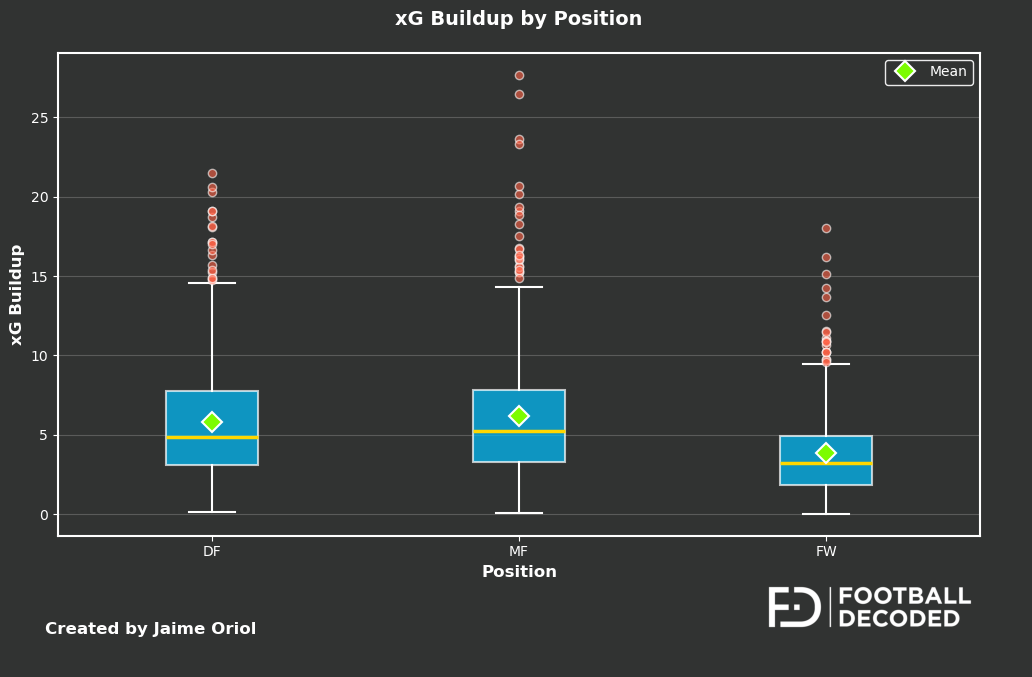


xG Buildup by Position:
                    mean       50%        max
position_clean                               
DF              5.833310  4.878119  21.517376
FW              3.855689  3.204569  18.003249
MF              6.196434  5.228208  27.680503


In [8]:
# Box plot: xG Buildup by position
fig, ax = create_boxplot_by_position(
    df=df_field,
    metric='xg_buildup',
    title='xG Buildup by Position',
    ylabel='xG Buildup',
    save_name='05_xg_buildup_by_position.png'
)
plt.show()

print("\nxG Buildup by Position:")
print(df_field.groupby('position_clean')['xg_buildup'].describe()[['mean', '50%', 'max']])

/tmp/ipykernel_84210/3093605716.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_pos, labels=positions, patch_artist=True,


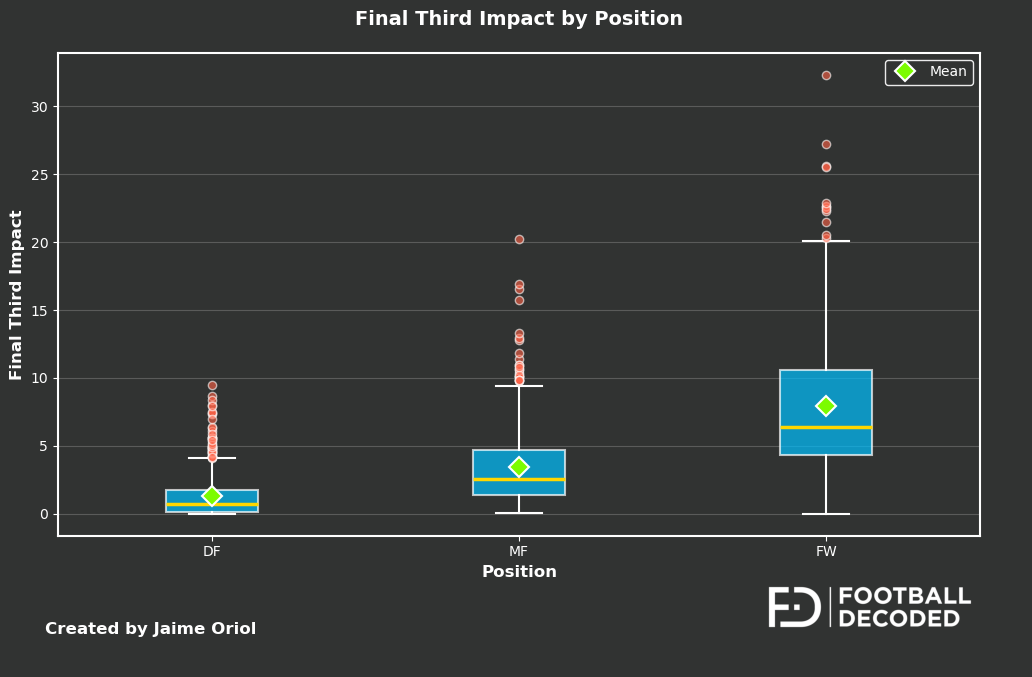


Final Third Impact by Position:
                    mean       50%        max
position_clean                               
DF              1.288004  0.723824   9.454207
FW              7.907874  6.392683  32.329130
MF              3.417192  2.542676  20.197576


In [9]:
# Box plot: Final Third Impact by position
fig, ax = create_boxplot_by_position(
    df=df_field,
    metric='final_third_impact',
    title='Final Third Impact by Position',
    ylabel='Final Third Impact',
    save_name='06_final_third_impact_by_position.png'
)
plt.show()

print("\nFinal Third Impact by Position:")
print(df_field.groupby('position_clean')['final_third_impact'].describe()[['mean', '50%', 'max']])

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


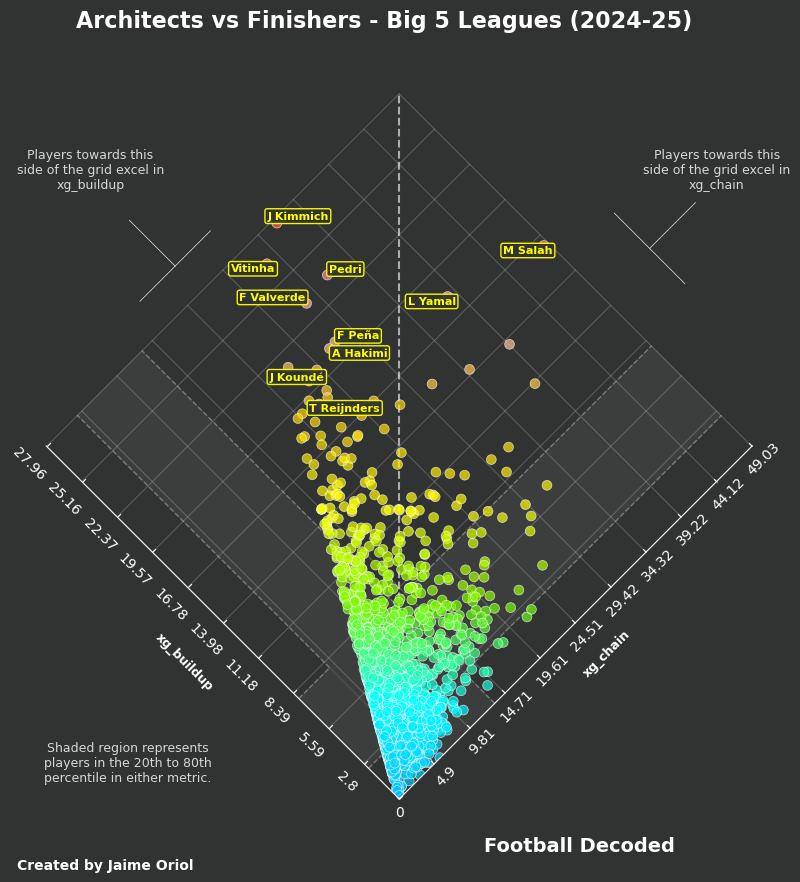


Players by Quadrant and Position:
quadrant        Architect  Complete  Finisher  Limited   All
position_clean                                              
DF                    122       218         4      277   621
FW                      0       108       129      113   350
MF                     42       242        31      178   493
All                   164       568       164      568  1464


In [10]:
# Prepare data for scatter: add percentiles
df_scatter = df_field.copy()
df_scatter['xg_chain_pct'] = df_scatter['xg_chain'].rank(pct=True) * 100
df_scatter['xg_buildup_pct'] = df_scatter['xg_buildup'].rank(pct=True) * 100

# Create diamond scatter
fig = create_diamond_scatter(
    df=df_scatter,
    x_metric='xg_buildup',
    y_metric='xg_chain',
    title='Architects vs Finishers - Big 5 Leagues (2024-25)',
    save_filename='07_architects_vs_finishers_scatter.png'
)
plt.show()

# Define 4 quadrants based on medians
chain_median = df_field['xg_chain'].median()
buildup_median = df_field['xg_buildup'].median()

def assign_quadrant(row):
    if row['xg_chain'] >= chain_median and row['xg_buildup'] >= buildup_median:
        return 'Complete'
    elif row['xg_chain'] >= chain_median and row['xg_buildup'] < buildup_median:
        return 'Finisher'
    elif row['xg_chain'] < chain_median and row['xg_buildup'] >= buildup_median:
        return 'Architect'
    else:
        return 'Limited'

df_field['quadrant'] = df_field.apply(assign_quadrant, axis=1)

# Count by quadrant and position
quadrant_summary = pd.crosstab(df_field['position_clean'], df_field['quadrant'], margins=True)
print("\nPlayers by Quadrant and Position:")
print(quadrant_summary)

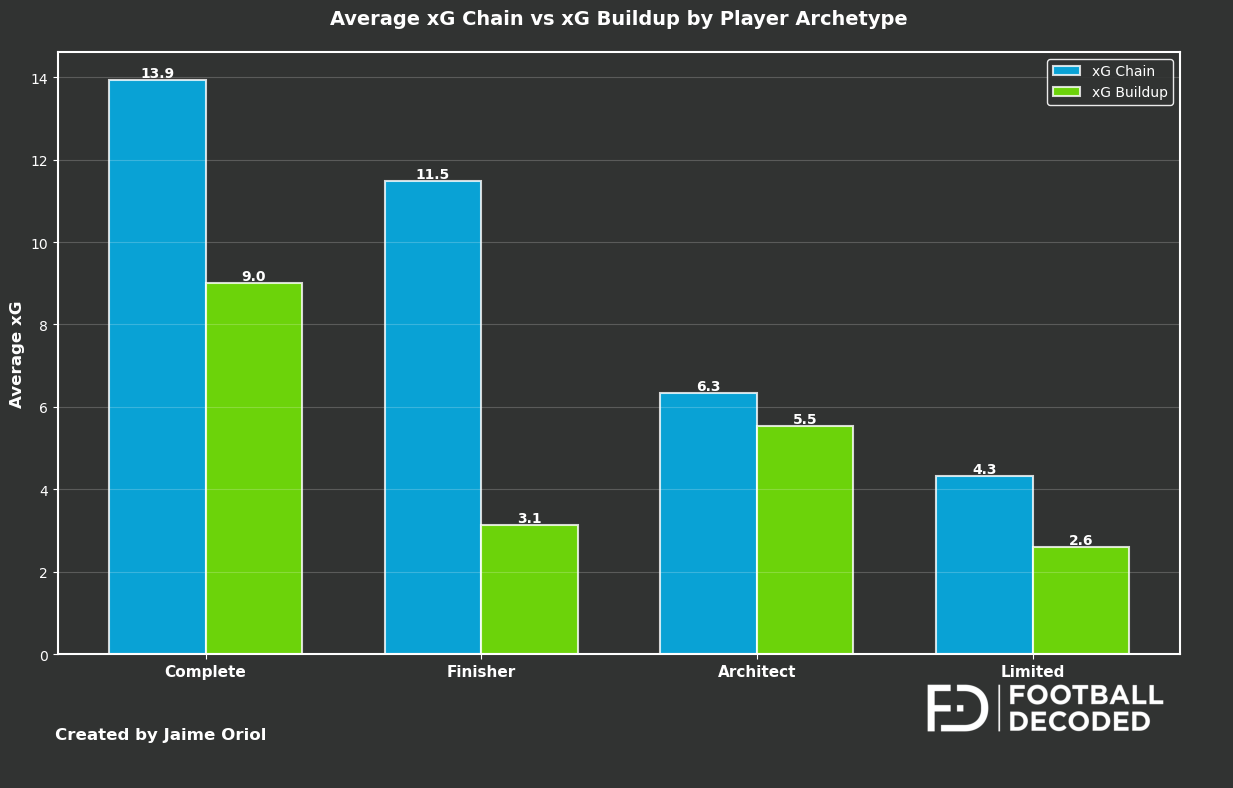


Average xG Chain and Buildup by Quadrant:
           xg_chain  xg_buildup  final_third_impact
quadrant                                           
Architect      6.33        5.53                0.81
Complete      13.92        9.01                4.90
Finisher      11.49        3.14                8.34
Limited        4.31        2.61                1.70


In [11]:
# Grouped bar chart: Chain vs Buildup by quadrant
fig, ax = create_grouped_bar_chain_buildup(
    df=df_field,
    save_name='08_chain_vs_buildup_by_archetype.png'
)
plt.show()

# Show detailed stats
print("\nAverage xG Chain and Buildup by Quadrant:")
print(df_field.groupby('quadrant')[['xg_chain', 'xg_buildup', 'final_third_impact']].mean().round(2))

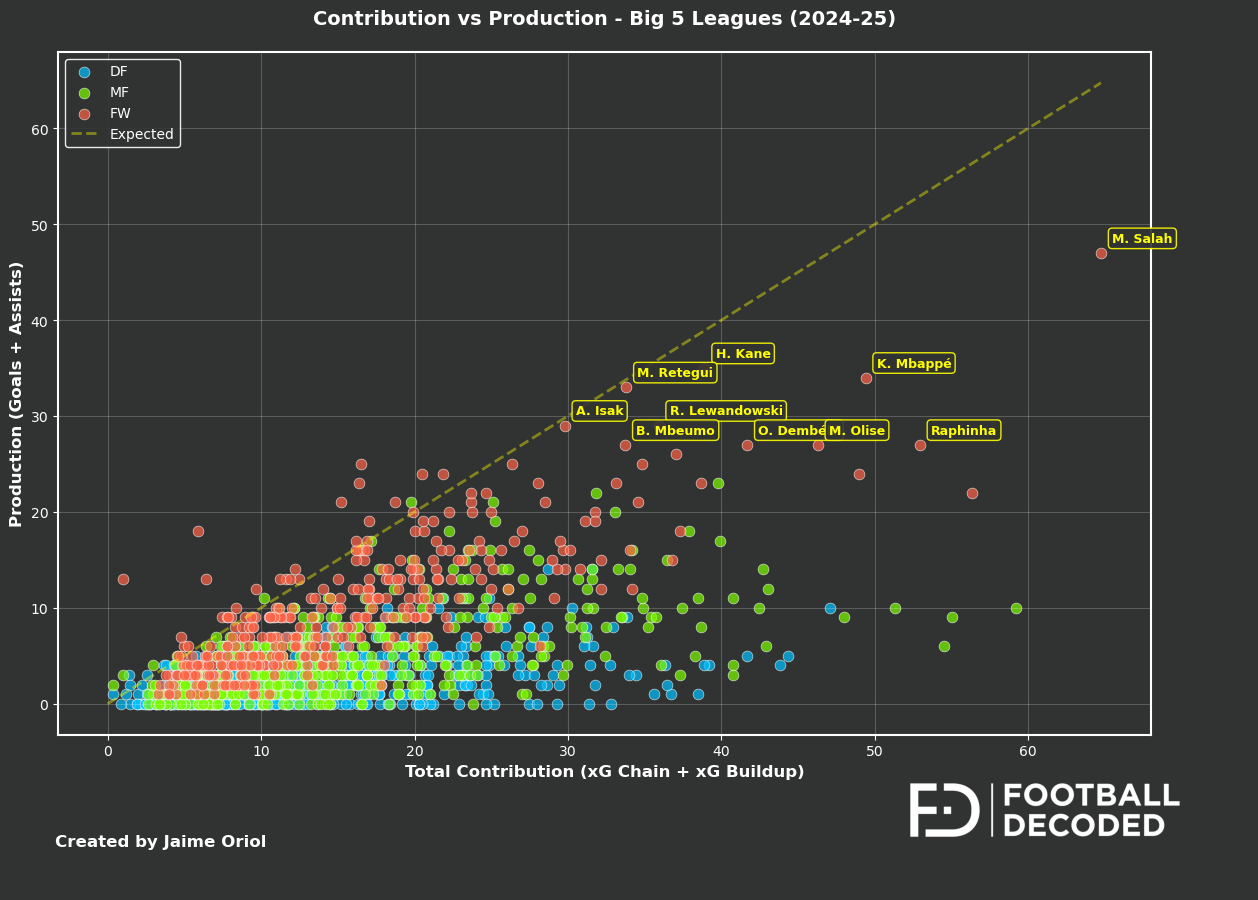


Correlation (Total Contribution vs G+A): 0.576

Correlation by Position:
DF: 0.484
MF: 0.592
FW: 0.816


In [12]:
# Scatter: Total contribution vs G+A
fig, ax = create_scatter_production(
    df=df_field,
    save_name='09_contribution_vs_production.png'
)
plt.show()

# Correlation
correlation = df_field['total_contribution'].corr(df_field['g_plus_a'])
print(f"\nCorrelation (Total Contribution vs G+A): {correlation:.3f}")

# By position
print("\nCorrelation by Position:")
for pos in ['DF', 'MF', 'FW']:
    df_pos = df_field[df_field['position_clean'] == pos]
    corr = df_pos['total_contribution'].corr(df_pos['g_plus_a'])
    print(f"{pos}: {corr:.3f}")

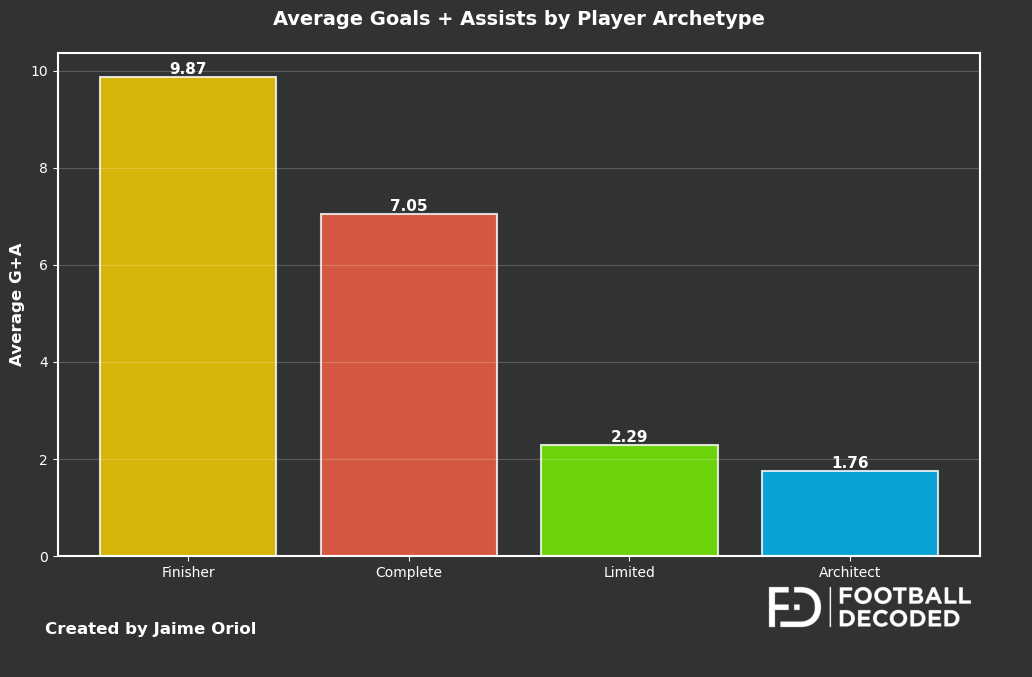


Average G+A by Quadrant:
quadrant
Finisher     9.871951
Complete     7.051056
Limited      2.294014
Architect    1.756098
Name: g_plus_a, dtype: float64

Top 10 'Complete' Players by G+A:
       player_name position          team  xg_chain  xg_buildup  g_plus_a
     Mohamed Salah       FW     Liverpool 48.535889   16.206758        47
        Harry Kane       FW Bayern Munich 30.192511    8.705299        35
     Kylian Mbappé       FW   Real Madrid 38.313464   11.081680        34
     Mateo Retegui       FW      Atalanta 26.736184    7.063065        33
Robert Lewandowski       FW     Barcelona 29.242780    6.659355        29
          Raphinha    FW,MF     Barcelona 39.282579   13.650435        27
      Bryan Mbeumo       FW     Brentford 24.377113    9.351835        27
   Ousmane Dembélé       FW     Paris S-G 32.066799    9.613210        27
     Michael Olise    FW,MF Bayern Munich 31.133057   15.147963        27
   Mason Greenwood    FW,MF     Marseille 26.145459   10.892804        

In [13]:
# Average G+A by quadrant
production_by_quadrant = df_field.groupby('quadrant')['g_plus_a'].mean().sort_values(ascending=False)

# Bar chart
fig, ax = create_bar_comparison(
    categories=production_by_quadrant.index.tolist(),
    values=production_by_quadrant.values.tolist(),
    title='Average Goals + Assists by Player Archetype',
    ylabel='Average G+A',
    colors=['gold', 'tomato', 'lawngreen', 'deepskyblue'],
    save_name='10_production_by_archetype.png'
)
plt.show()

print("\nAverage G+A by Quadrant:")
print(production_by_quadrant)

# Top complete players
complete_players = df_field[df_field['quadrant'] == 'Complete'].nlargest(10, 'g_plus_a')
print("\nTop 10 'Complete' Players by G+A:")
print(complete_players[['player_name', 'position', 'team', 'xg_chain', 'xg_buildup', 'g_plus_a']].to_string(index=False))

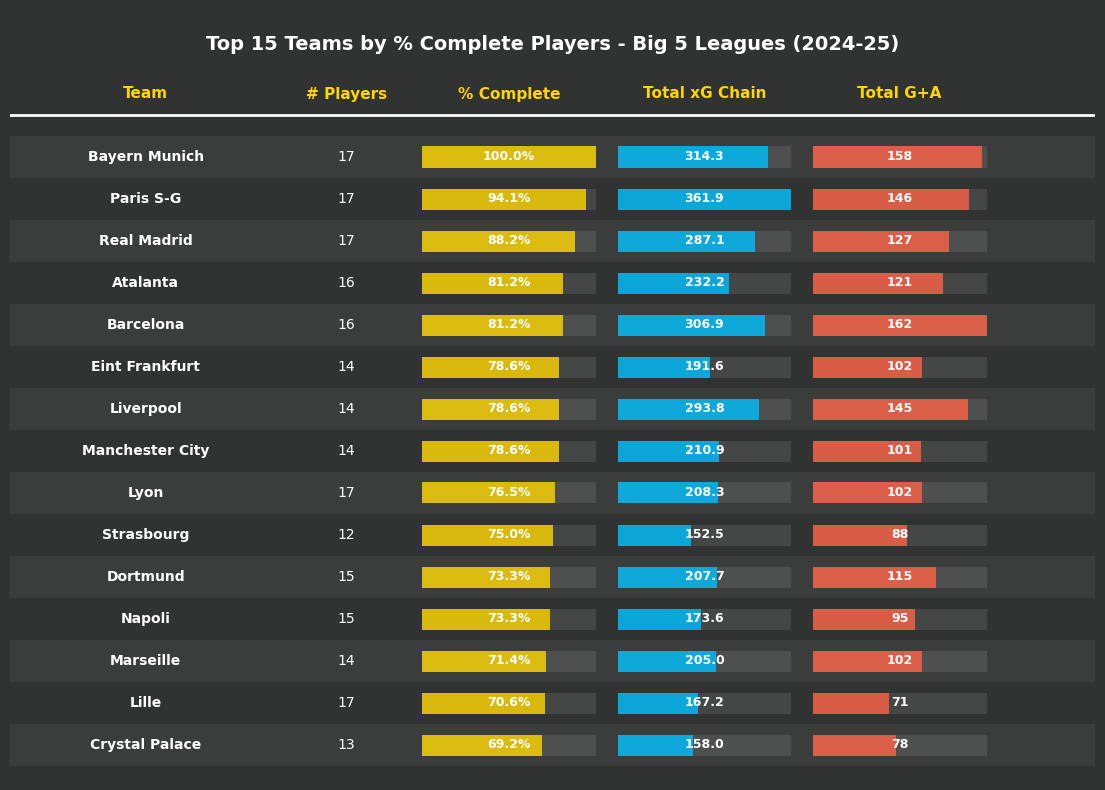


Correlation (% Complete Players vs Team xG Chain): 0.888


In [14]:
# Calculate team metrics
team_summary = df_field.groupby('team').agg({
    'player_name': 'count',
    'xg_chain': 'sum',
    'xg_buildup': 'sum',
    'g_plus_a': 'sum'
}).rename(columns={'player_name': 'num_players'})

# Add % complete players per team
complete_by_team = df_field[df_field['quadrant'] == 'Complete'].groupby('team').size()
team_summary['complete_players'] = complete_by_team
team_summary['complete_players'] = team_summary['complete_players'].fillna(0)
team_summary['pct_complete'] = (team_summary['complete_players'] / team_summary['num_players'] * 100).round(1)

# Filter teams with at least 10 players in sample
team_summary = team_summary[team_summary['num_players'] >= 10]

# Create visual table
fig, ax = create_team_table(
    team_summary=team_summary,
    top_n=15,
    save_name='11_team_table.png'
)
plt.show()

# Correlation: % complete vs total xG chain
correlation = team_summary['pct_complete'].corr(team_summary['xg_chain'])
print(f"\nCorrelation (% Complete Players vs Team xG Chain): {correlation:.3f}")

In [15]:
# Export full dataset with classifications
export_cols = ['player_name', 'position', 'team', 'league', 'minutes', 
               'xg_chain', 'xg_buildup', 'final_third_impact', 'total_contribution',
               'goals', 'assists', 'g_plus_a', 'archetype', 'quadrant']

df_export = df_field[export_cols].sort_values('xg_chain', ascending=False)
df_export.to_csv('figures/full_data.csv', index=False)

print("Data exported to: ../figures/architects_vs_finishers/full_data.csv")
print(f"\nTotal players analyzed: {len(df_field)}")
print(f"Figures saved to: ../figures/architects_vs_finishers/")
print(f"Total figures: 11")

# Final summary
print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"Season: 2024-25")
print(f"Leagues: Big 5 (ENG, ESP, ITA, GER, FRA)")
print(f"Players: {len(df_field)} (800+ minutes)")
print(f"\nKey Findings:")
print(f"- {archetype_pct.get('Architect', 0):.1f}% are Architects (low Final Third Impact)")
print(f"- {archetype_pct.get('Balanced', 0):.1f}% are Balanced")
print(f"- {archetype_pct.get('Finisher', 0):.1f}% are Finishers (high Final Third Impact)")
print(f"\n- Complete players average {production_by_quadrant.get('Complete', 0):.2f} G+A")
print(f"- Limited players average {production_by_quadrant.get('Limited', 0):.2f} G+A")
print(f"- Difference: {production_by_quadrant.get('Complete', 0) - production_by_quadrant.get('Limited', 0):.2f} G+A")
print("\n- Teams with >75% complete players have {:.1f}% more xG Chain".format(
    (team_summary[team_summary['pct_complete'] > 75]['xg_chain'].mean() / 
     team_summary[team_summary['pct_complete'] <= 75]['xg_chain'].mean() - 1) * 100
))
print("="*60)

Data exported to: ../figures/architects_vs_finishers/full_data.csv

Total players analyzed: 1464
Figures saved to: ../figures/architects_vs_finishers/
Total figures: 11

ANALYSIS COMPLETE
Season: 2024-25
Leagues: Big 5 (ENG, ESP, ITA, GER, FRA)
Players: 1464 (800+ minutes)

Key Findings:
- 47.2% are Architects (low Final Third Impact)
- 28.0% are Balanced
- 24.8% are Finishers (high Final Third Impact)

- Complete players average 7.05 G+A
- Limited players average 2.29 G+A
- Difference: 4.76 G+A

- Teams with >75% complete players have 109.6% more xG Chain
